In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import cauchy, norm, laplace
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

import pymc3 as pm

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# The dataset: Boston House prices

In [2]:
feats, labels = datasets.load_boston(True)
data = datasets.load_boston()
X = pd.DataFrame(feats, columns=data.feature_names)
y = labels

scaler = StandardScaler()
X_standardized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [3]:
print(data.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

# The standard model: Linear regression with sklearn

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

### Model definition

In [4]:
lr = LinearRegression()

### Inference

In [5]:
lr.fit(X_standardized, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

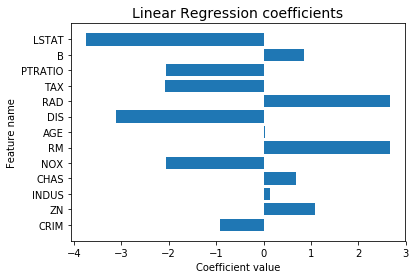

In [6]:
fig, ax = plt.subplots(1,1)
ax.barh(data.feature_names, lr.coef_);
ax.set_xlabel("Coefficient value");
ax.set_ylabel("Feature name");
ax.set_title("Linear Regression coefficients", fontsize=14);

### Criticism

In [7]:
y_pred = lr.predict(X_standardized)

def mape(y, y_hat):
    """Calculates the Mean Absolute Percentage Error (MAPE)"""
    return np.mean(np.abs(y - y_hat) / y)

print("MAPE: %f" % mape(y, y_pred))

MAPE: 0.164317


In [8]:
def overview_plot(y, y_pred, instance_start=0, instance_end=None):
    if y_pred.ndim > 1:
        comp = pd.DataFrame({"y": y, "y_pred": y_pred.mean(axis=0)})
        comp["bound_5"] = np.nanpercentile(y_pred, 5.0, axis=0)
        comp["bound_10"] = np.nanpercentile(y_pred, 10.0, axis=0)
        comp["bound_20"] = np.nanpercentile(y_pred, 20.0, axis=0)
        comp["bound_80"] = np.nanpercentile(y_pred, 80.0, axis=0)
        comp["bound_90"] = np.nanpercentile(y_pred, 90.0, axis=0)
        comp["bound_95"] = np.nanpercentile(y_pred, 95.0, axis=0)
    else:
        comp = pd.DataFrame({"y": y, "y_pred": y_pred})
        
    end = comp.shape[0] if instance_end is None else instance_end
    comp_subset = comp.iloc[instance_start:end].copy()
    comp_subset["instance_id"] = comp_subset.index
    plot_width = min(24, end * 0.2)
    fig, ax = plt.subplots(1, 1, figsize=(plot_width, 6))
    if y_pred.ndim > 1:
        ax.vlines(comp_subset.instance_id, comp_subset.bound_5, comp_subset.bound_95, color="orange", alpha=0.3, linewidth=1, zorder=0, label="90 percent")
        ax.vlines(comp_subset.instance_id, comp_subset.bound_10, comp_subset.bound_90, color="orange", alpha=0.2, linewidth=3, zorder=0, label="80 percent")
        ax.vlines(comp_subset.instance_id, comp_subset.bound_20, comp_subset.bound_80, color="orange", alpha=0.2, linewidth=5, zorder=0, label="60 percent")
    ax.scatter(comp_subset.instance_id, comp_subset.y, color="steelblue", zorder=1, s=15, label="Actual")
    ax.scatter(comp_subset.instance_id, comp_subset.y_pred, color="orange", zorder=1, s=15, label="Prediction")
    ax.vlines(comp_subset.instance_id, comp_subset.y, comp_subset.y_pred, linestyle="--", color="black", linewidth=1, zorder=0, alpha=0.3)
    ax.set_xlabel("Instance IDs")
    ax.set_ylabel("Target value (price)")
    ax.set_title("Overview of instances", fontsize=14)
    ax.legend()
    return ax

In [9]:
def uncertainty_plot(y, y_pred, instance_start=0, instance_end=None):
    comp = pd.DataFrame({"y": y, "y_pred": y_pred.mean(axis=0)})
    comp["uncertainty"] = y_pred.std(axis=0)
        
    end = comp.shape[0] if instance_end is None else instance_end
    comp_subset = comp.iloc[instance_start:end].copy()
    comp_subset["instance_id"] = comp_subset.index
    plot_width = min(24, end * 0.2)
    fig, ax = plt.subplots(1, 1, figsize=(plot_width, 6))
    
    ax.bar(comp_subset.instance_id, comp_subset.uncertainty, color="steelblue", zorder=1, label="Uncertainty")
    ax.set_xlabel("Instance IDs")
    ax.set_ylabel("Uncertainty")
    ax.set_title("Overview of instances", fontsize=14)
    return ax

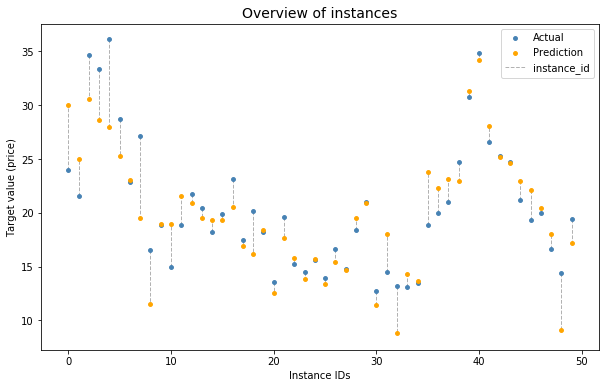

In [10]:
overview_plot(y, y_pred, 0, 50);

# Bayesian Linear Regression

## Single variable model to get started

### Model definition

The variable "NOX" (*nitric oxides concentration (parts per 10 million)*) is used to predict the
price of the respective house.

In [11]:
model = pm.Model()

In [12]:
with model:
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    intercept = pm.Normal('Intercept', 0, sd=20)
    m = pm.Normal('m', mu=0, sd=1)
    y_hat = pm.Normal('y_hat', mu=m * X_standardized["NOX"] + intercept, sd=sigma, observed=y)

#### The prior choices

* The Half-Cauchy distribution for variance terms
* The Normal distribution for model weights and target variable, using L2 regularization (ridge)
* The Laplace distribution as alternative for model weights to reach L1 (LASSO)


Sources:

Why Half-Cauchy for variance terms?: https://stats.stackexchange.com/questions/237847/what-are-the-properties-of-a-half-cauchy-distribution

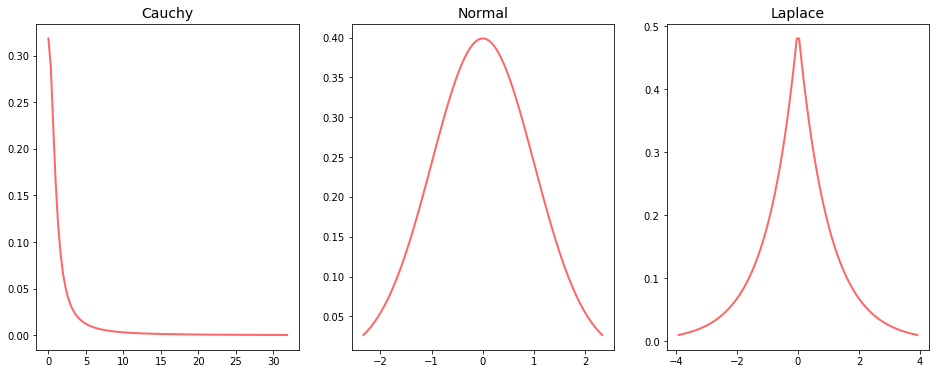

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
dists = {
    "Half-Cauchy": np.linspace(0, cauchy.ppf(0.99), 100),
    "Normal": np.linspace(norm.ppf(0.01), norm.ppf(0.99), 100),
    "Laplace": np.linspace(laplace.ppf(0.01), laplace.ppf(0.99), 100)
        }
x = np.linspace(0, cauchy.ppf(0.99), 100)
axs[0].plot(x, cauchy.pdf(x), 'r-', lw=2, alpha=0.6, label='Cauchy')
axs[0].set_title("Cauchy", fontsize=14)

x = np.linspace(norm.ppf(0.01), norm.ppf(0.99), 100)
axs[1].plot(x, norm.pdf(x), 'r-', lw=2, alpha=0.6, label='normal pdf')
axs[1].set_title("Normal", fontsize=14)

x = np.linspace(laplace.ppf(0.01), laplace.ppf(0.99), 100)
axs[2].plot(x, laplace.pdf(x), 'r-', lw=2, alpha=0.6, label='Laplace');
axs[2].set_title("Laplace", fontsize=14);

### Inference

In [14]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)
    burned_trace = trace[9000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [m]
>Metropolis: [Intercept]
>Metropolis: [sigma]
Sampling 4 chains: 100%|██████████| 74000/74000 [00:17<00:00, 4295.48draws/s]
The number of effective samples is smaller than 10% for some parameters.


The Metropolis-Hastings sampler is used to approximate the posterior distribution of
our weight m, the intercept and the overall variance sigma. Since the chains of the
MCMC sampling require some time (steps) to reach meaningful values, the whole trace of
generated values is cut-off at half of its overall size. The remaining trace is sometimes
referred to as the burned trace. It should contain much more stable values.

The following trace plot displays an overview of the inference step. It displays the 
generated values of all four MCMC chains for each infered variable and shows them as
density plot, as well as raw signals.

The four density plots are quite similar for each variable, which indicates that the different
chains come to the same result which points to a stable model.

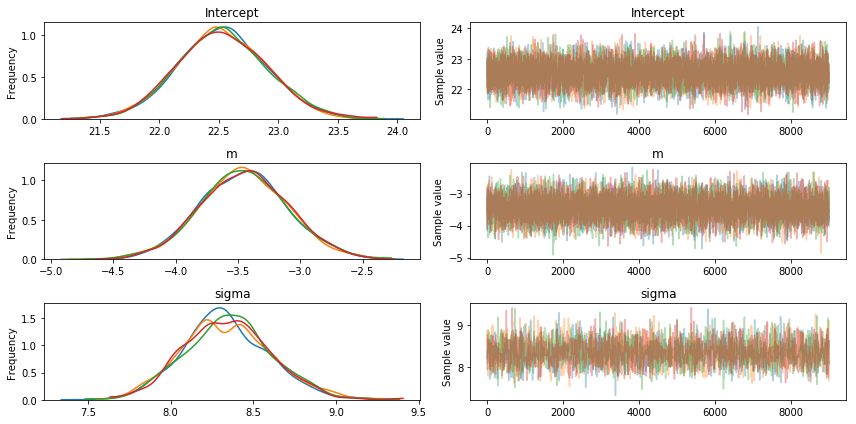

In [15]:
pm.traceplot(burned_trace);

The following autocorrelation plot provides further evidence that the model reached a stable
final state:

It is desirable to have low autocorrelation (the correlation of the same sequence samples with a lag)
since it shows that individual samples are not connected to previous ones and the true posterior might
reveal itself easier. ???

https://stats.stackexchange.com/questions/110268/why-is-it-desirable-to-have-low-auto-correlation-in-mcmc

http://doingbayesiandataanalysis.blogspot.com/2011/11/thinning-to-reduce-autocorrelation.html

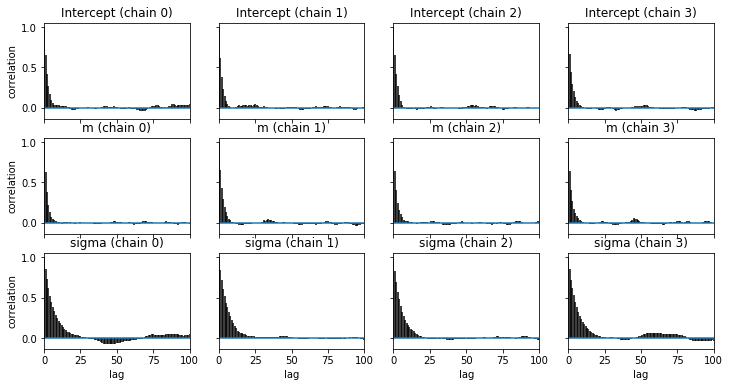

In [16]:
pm.autocorrplot(burned_trace);

Finally we look at the posterior plots. It displays the posteriors of the calculated variables.
If we only look at the means (as we would in classic linear regression) we get the following
results:

* Intercept: 22.5 with credible interval 21.8 to 23.3
* NOX: -3.5 with credible interval -4.1 to -2.7
* Sigma: 8.4 with credible interval 7.8 to 8.9

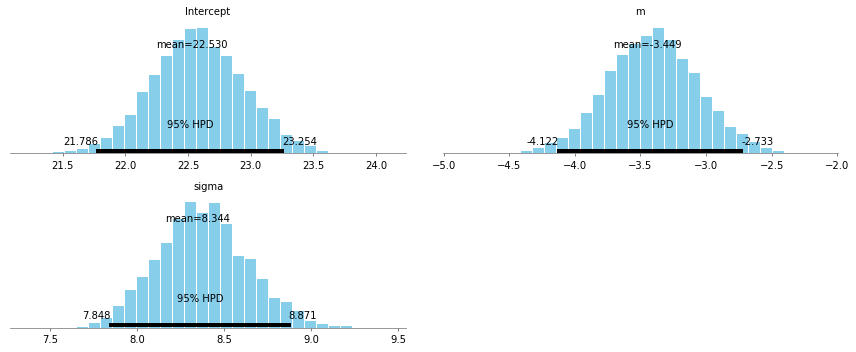

In [17]:
pm.plot_posterior(burned_trace);

### Criticism

For the classic example MAPE, a point estimate, was used to criticize the model. We can do the same:

In [18]:
m_coeff = burned_trace.get_values("m").mean()
intercept_coeff = burned_trace.get_values("Intercept").mean()

y_pred = X_standardized["NOX"] * m_coeff + intercept_coeff

print("MAPE: %f" % mape(y, y_pred))

MAPE: 0.303958


The result is obviously much worse since we only considered one possible variable, 
so we will revisit this number once we added the other variables.

But since we have distributions, we can perform additional critic towards our model to
learn more about it: **Posterior predictive checks**

https://stackoverflow.com/questions/37312817/pymc3-bayesian-linear-regression-prediction-with-sklearn-datasets

https://docs.pymc.io/notebooks/posterior_predictive.html

http://edwardlib.org/tutorials/criticism

In [19]:
y_pred_samples = pm.sample_ppc(burned_trace, model=model, samples=500)

100%|██████████| 500/500 [00:00<00:00, 1075.02it/s]


In [20]:
def individual_ppc_check(y, y_pred_samples, instance_id, ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    ax.hist(y_pred_samples["y_hat"][:, instance_id], bins=30, label="Posterior")
    ax.axvline(y[instance_id], c="r", label="Actual: %2.2f" % y[instance_id])
    pred = y_pred_samples["y_hat"][:, instance_id].mean()
    ax.axvline(pred, c="black", label="Avg prediction: %2.2f" % pred)
    ax.set_title("PPC for instance %s" % instance_id, fontsize=14)
    ax.set_xlabel("Target value (price)")
    ax.set_ylabel("Count of samples")
    
    ax.legend()
    return ax

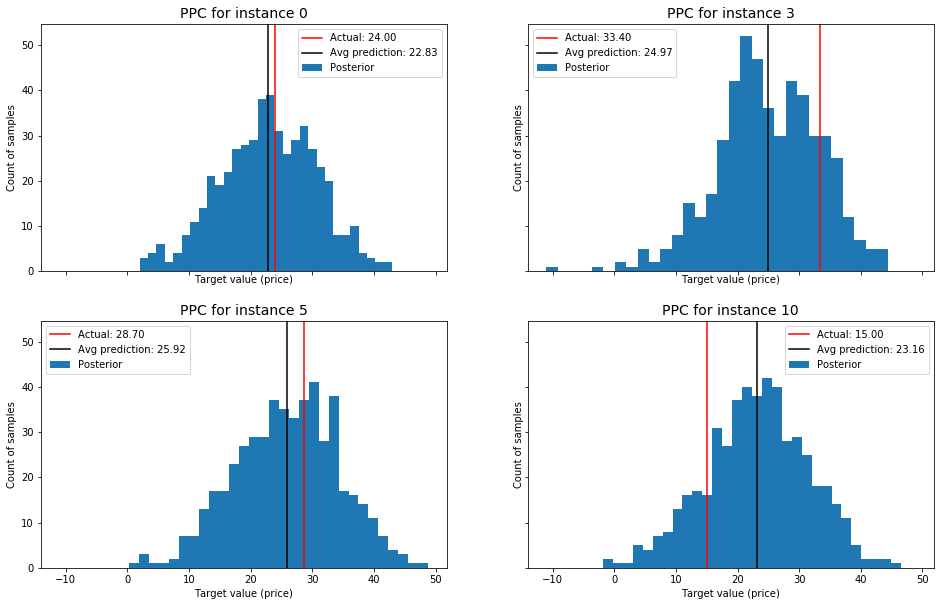

In [21]:
instances = [0, 3, 5, 10]

fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True)

for i, i_id in enumerate(instances):
    individual_ppc_check(y, y_pred_samples, i_id, axes[int(i / 2)][i % 2])

* Instance 0: Mean of all samples and the true value are very close together. For this sample
the prediction already works.
* Instance 3: In this case, the prediction is way off base
* Instance 5 and 10: Medium deviations

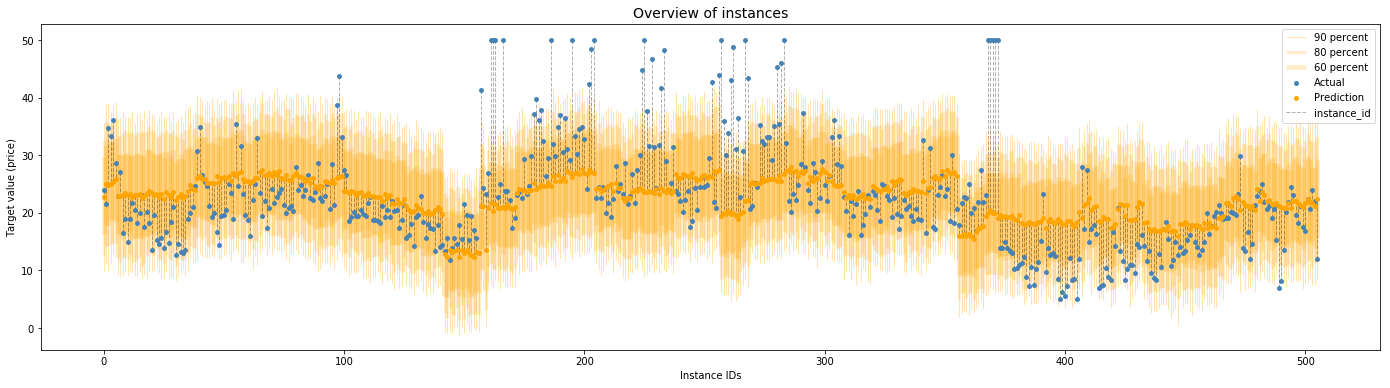

In [22]:
overview_plot(y, y_pred_samples["y_hat"]);

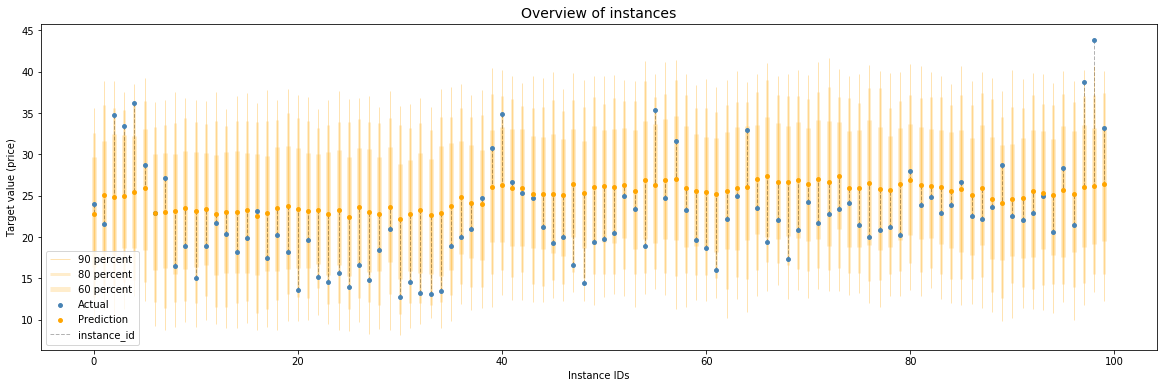

In [23]:
overview_plot(y, y_pred_samples["y_hat"], 0, 100);

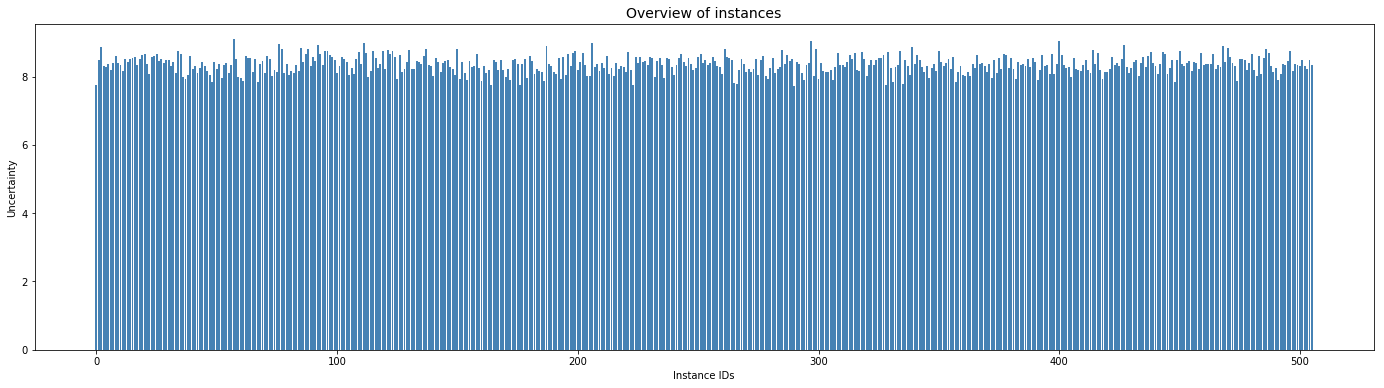

In [24]:
uncertainty_plot(y, y_pred_samples["y_hat"]);

## Multiple variables with normal priors (ridge regression)

### Model definition

In [25]:
model = pm.Model()
with model:
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    intercept = pm.Normal('Intercept', 0, sd=20)
    
    weights = intercept
    
    for c in X_standardized.columns:
        weights += pm.Normal(c, mu=0, sd=1) * X_standardized[c]
    
    y_hat = pm.Normal('y_hat', mu=weights, sd=sigma, observed=y)
    
    # alternative formulation without for loop:
    # y_hat = pm.Normal('y_hat', mu=tt.dot(beta, X_standardized.values.T) + intercept, sd=sigma, observed=y)

In [26]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)
    burned_trace = trace[12000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [LSTAT]
>Metropolis: [B]
>Metropolis: [PTRATIO]
>Metropolis: [TAX]
>Metropolis: [RAD]
>Metropolis: [DIS]
>Metropolis: [AGE]
>Metropolis: [RM]
>Metropolis: [NOX]
>Metropolis: [CHAS]
>Metropolis: [INDUS]
>Metropolis: [ZN]
>Metropolis: [CRIM]
>Metropolis: [Intercept]
>Metropolis: [sigma]
Sampling 4 chains: 100%|██████████| 74000/74000 [01:30<00:00, 816.84draws/s]
The number of effective samples is smaller than 10% for some parameters.


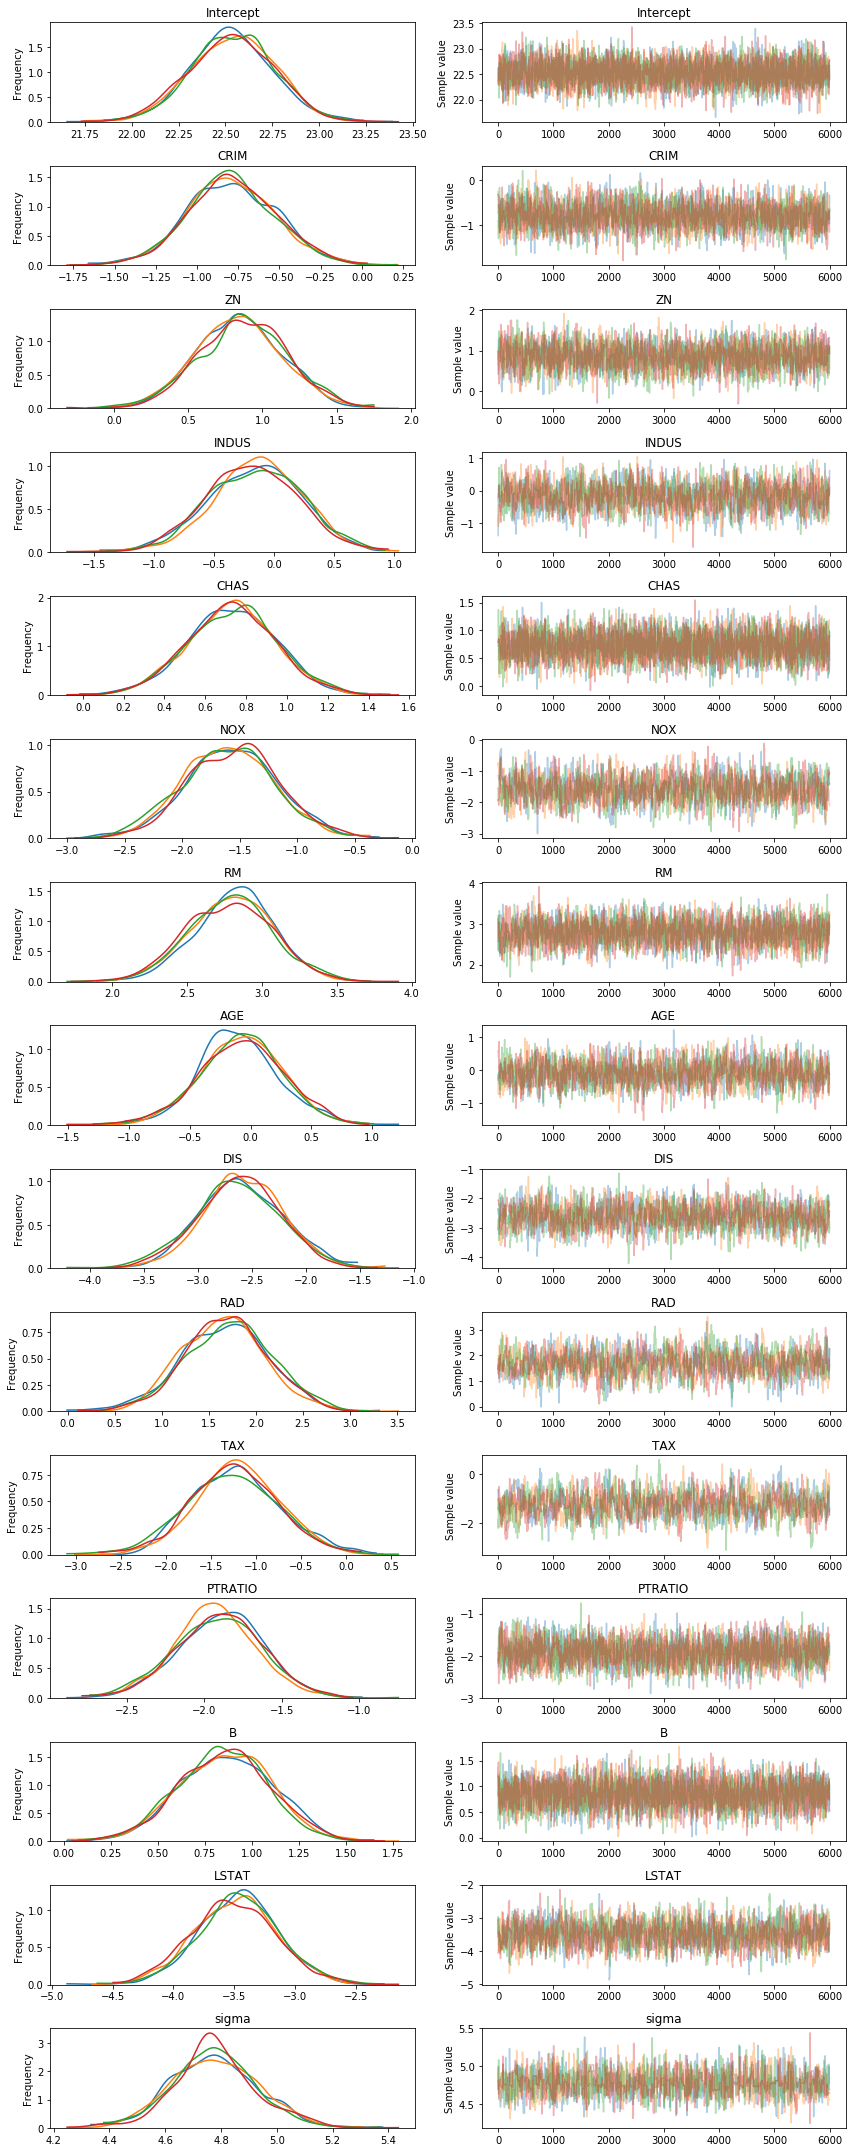

In [27]:
pm.traceplot(burned_trace);

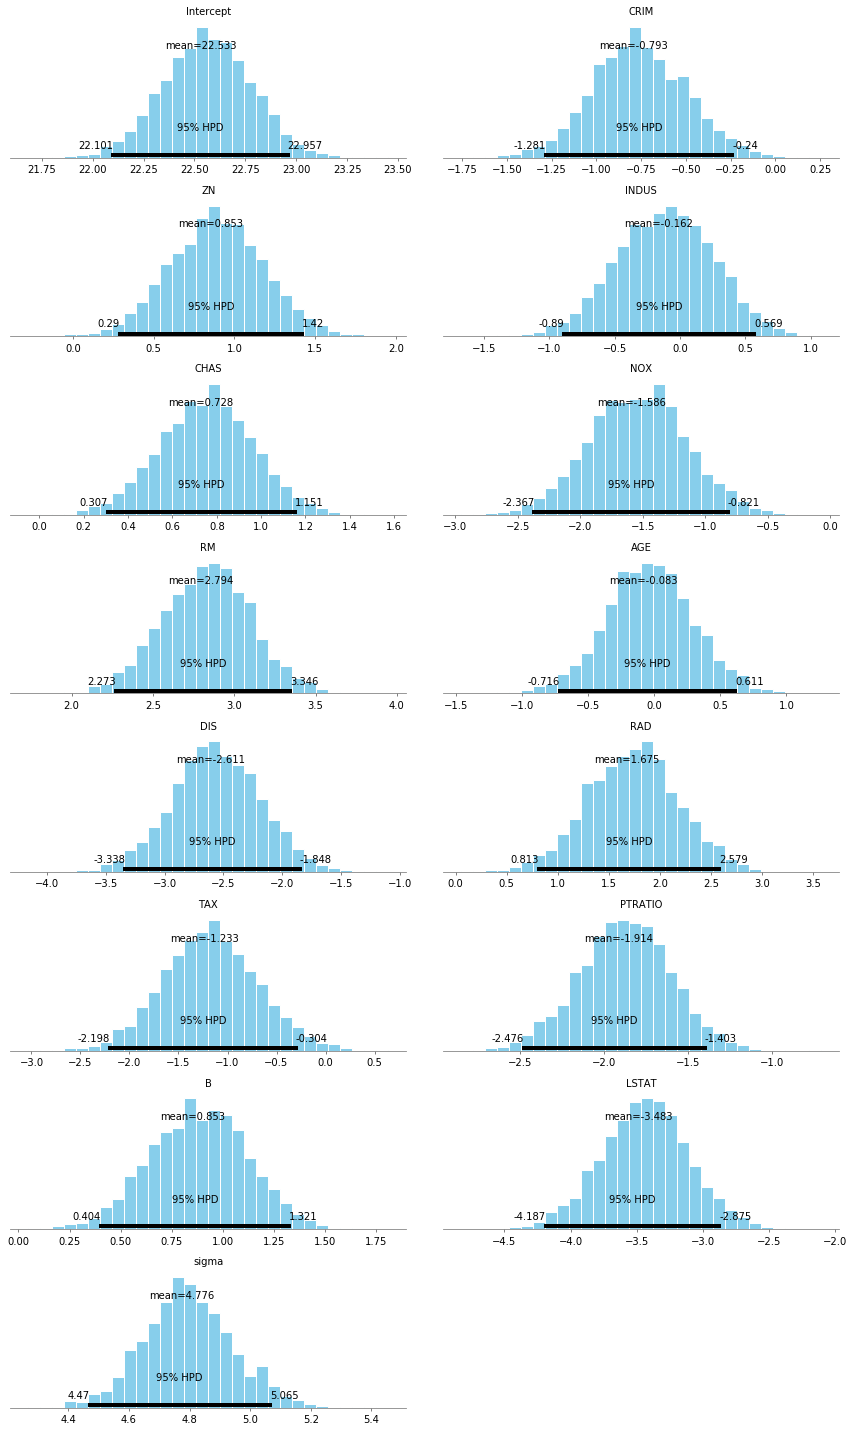

In [28]:
pm.plot_posterior(burned_trace);

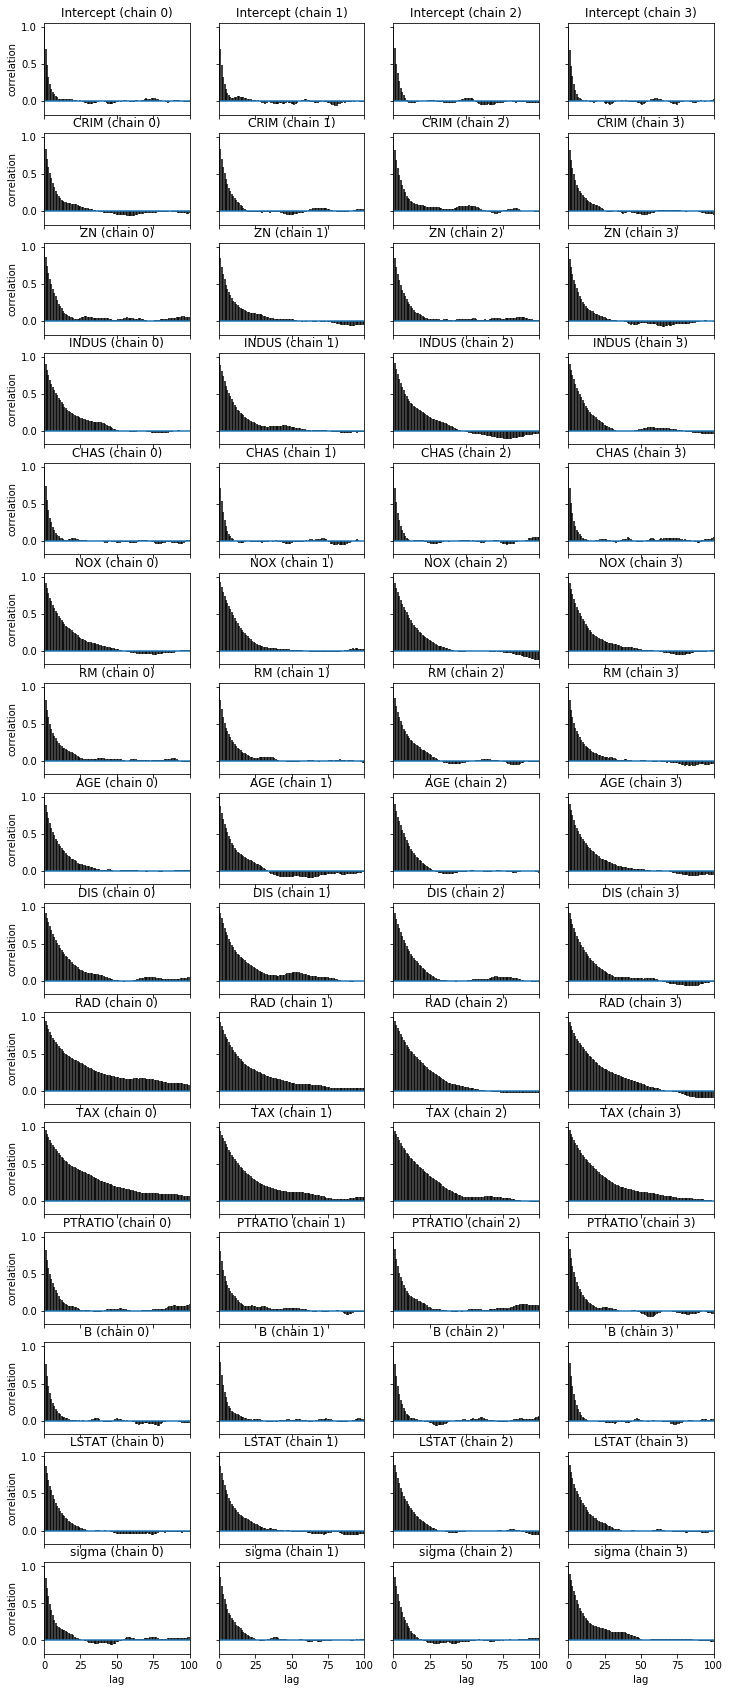

In [29]:
pm.autocorrplot(burned_trace);

In [30]:
y_pred_samples = pm.sample_ppc(burned_trace, model=model, samples=500)

100%|██████████| 500/500 [00:00<00:00, 601.31it/s]


In [31]:
y_pred = y_pred_samples["y_hat"].mean(axis=0)
print("MAPE: %.4f" % mape(y, y_pred))

MAPE: 0.1620


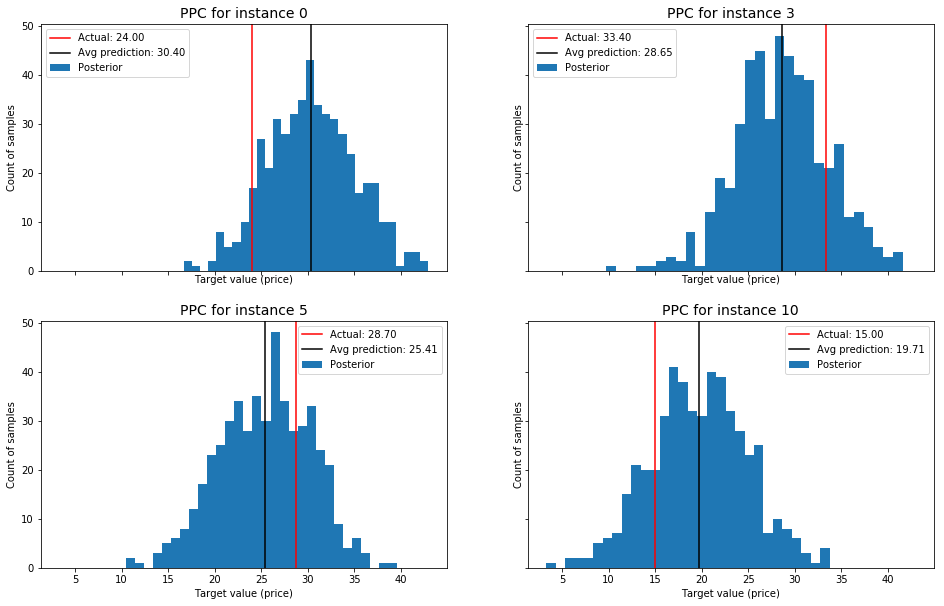

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True)

for i, i_id in enumerate(instances):
    individual_ppc_check(y, y_pred_samples, i_id, axes[int(i / 2)][i % 2])

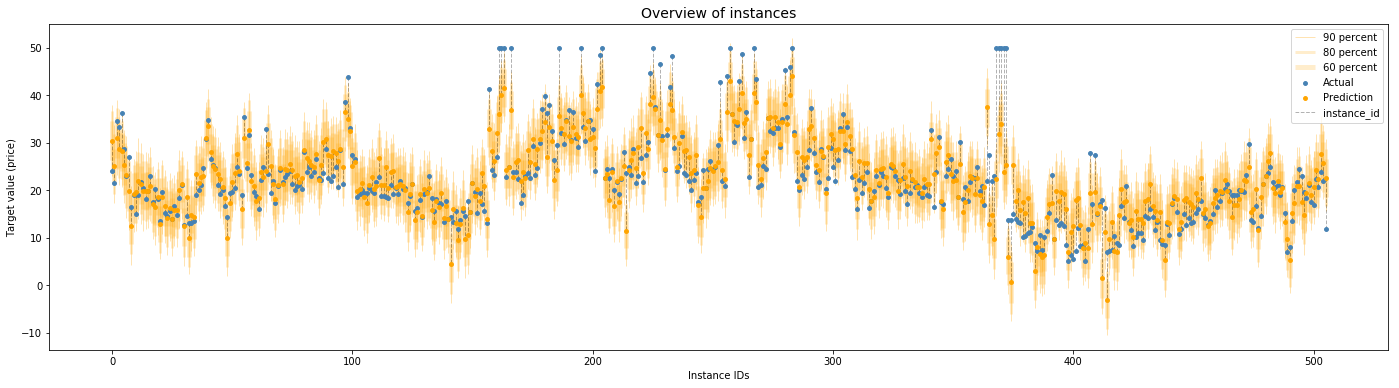

In [33]:
overview_plot(y, y_pred_samples["y_hat"]);

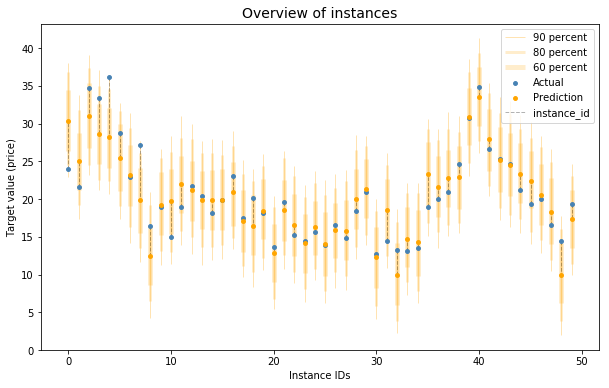

In [34]:
overview_plot(y, y_pred_samples["y_hat"], 0, 50);

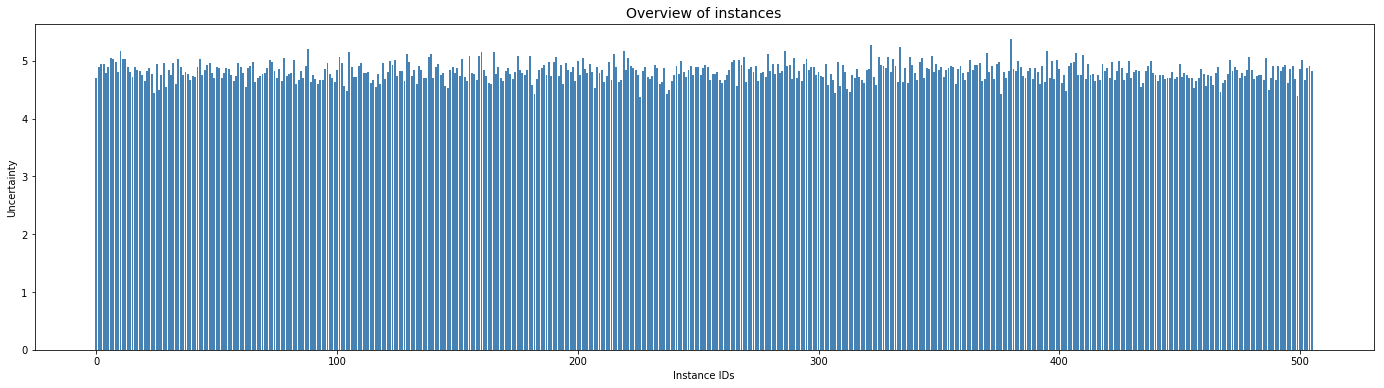

In [35]:
uncertainty_plot(y, y_pred_samples["y_hat"]);

### Other approximations

### No U-Turn Sampler (NUTS)

PyMC3 provides several samplers that can be more appropriate to reach convergence.

https://stats.stackexchange.com/questions/311813/can-somebody-explain-to-me-nuts-in-english

In [517]:
model = pm.Model()
with model:
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    intercept = pm.Normal('Intercept', 0, sd=20)
    
    weights = intercept
    
    for c in X_standardized.columns:
        weights += pm.Normal(c, mu=0, sd=20) * X_standardized[c]
    
    y_hat = pm.Normal('y_hat', mu=weights, sd=sigma, observed=y)

In [518]:
with model:
    #Use Maximum A Posteriori (MAP) optimisation as initial value for MCMC
    start = pm.find_MAP()

    # Use the No-U-Turn Sampler
    step = pm.NUTS()

    # Calculate the trace
    trace = pm.sample(
        3000, step, start, 
        random_seed=42, progressbar=True,
        tune=1200
    )
    burned_trace = trace[1000:]

logp = -1,557.3, ||grad|| = 0.05914: 100%|██████████| 78/78 [00:00<00:00, 856.99it/s]  
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [LSTAT, B, PTRATIO, TAX, RAD, DIS, AGE, RM, NOX, CHAS, INDUS, ZN, CRIM, Intercept, sigma]
Sampling 4 chains: 100%|██████████| 16800/16800 [00:53<00:00, 314.41draws/s]


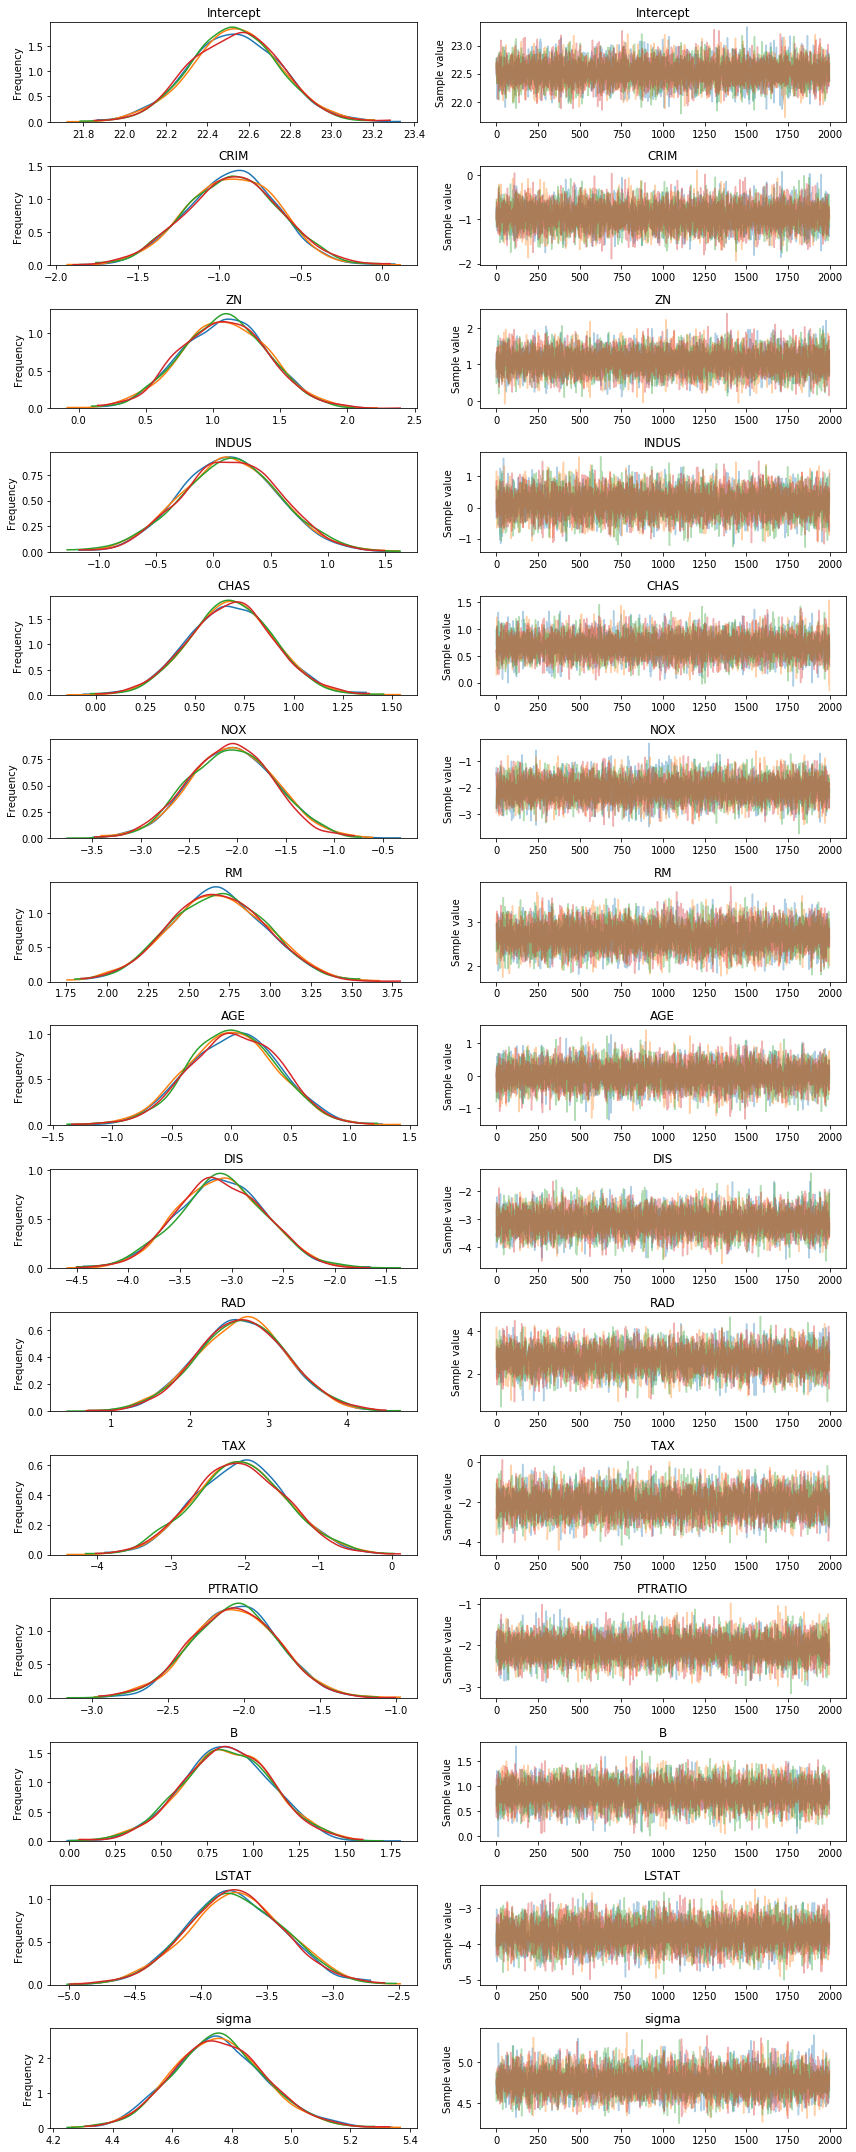

In [519]:
pm.traceplot(burned_trace);

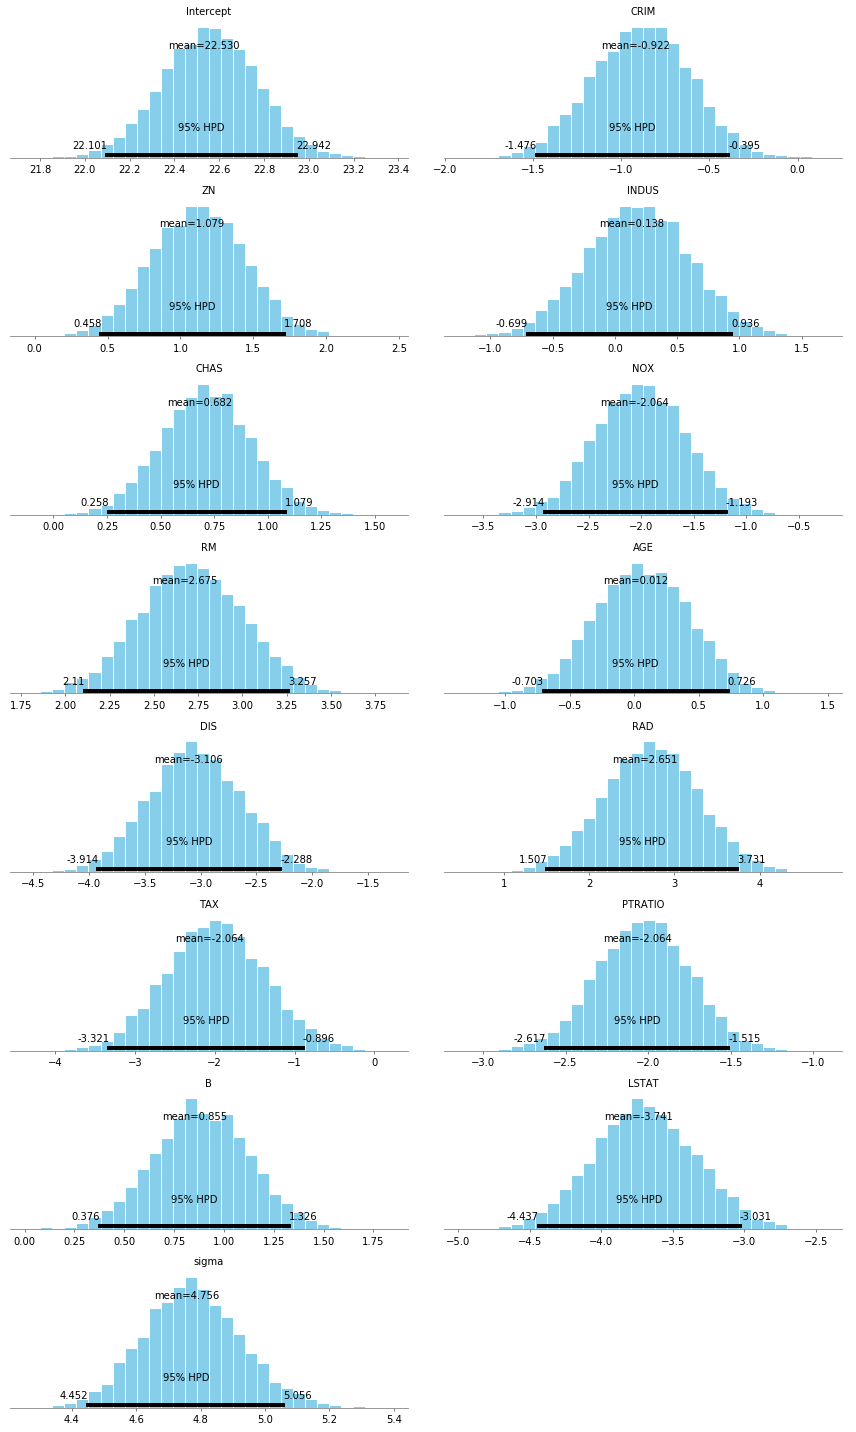

In [520]:
pm.plot_posterior(burned_trace);

In [521]:
y_pred_samples = pm.sample_ppc(burned_trace, model=model, samples=500)

100%|██████████| 500/500 [00:00<00:00, 621.08it/s]


In [522]:
y_pred = y_pred_samples["y_hat"].mean(axis=0)
mape(y, y_pred)

0.1645861872080923

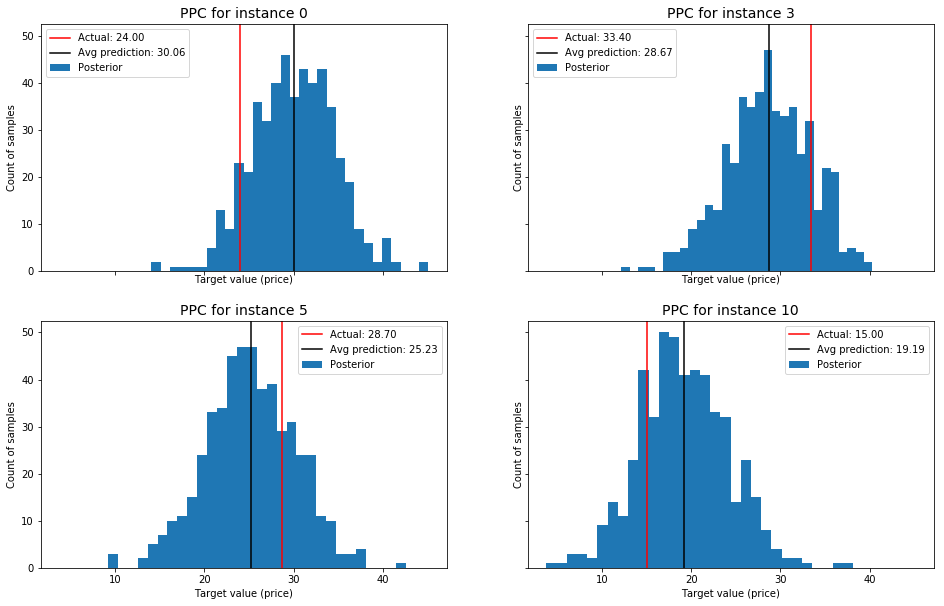

In [523]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True)

for i, i_id in enumerate(instances):
    individual_ppc_check(y, y_pred_samples, i_id, axes[int(i / 2)][i % 2])

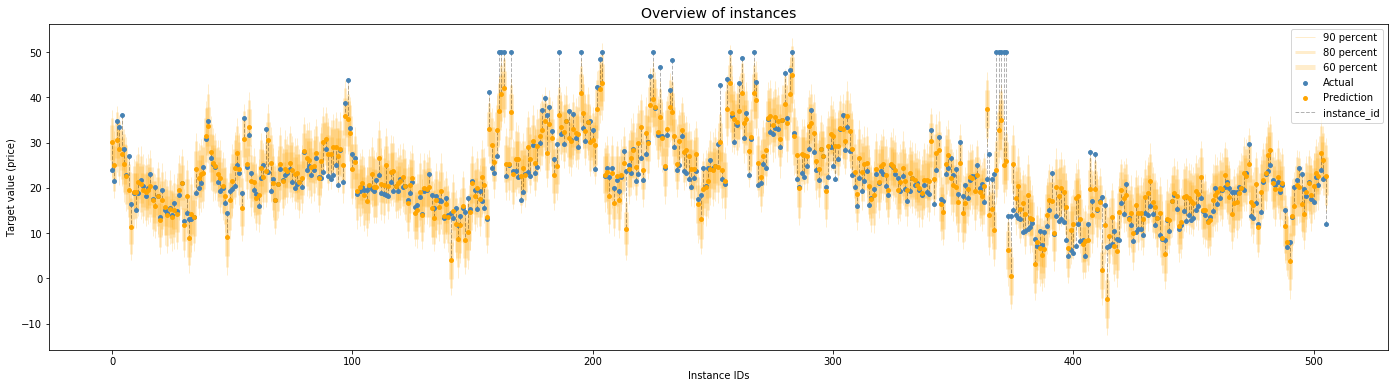

In [524]:
overview_plot(y, y_pred_samples["y_hat"]);

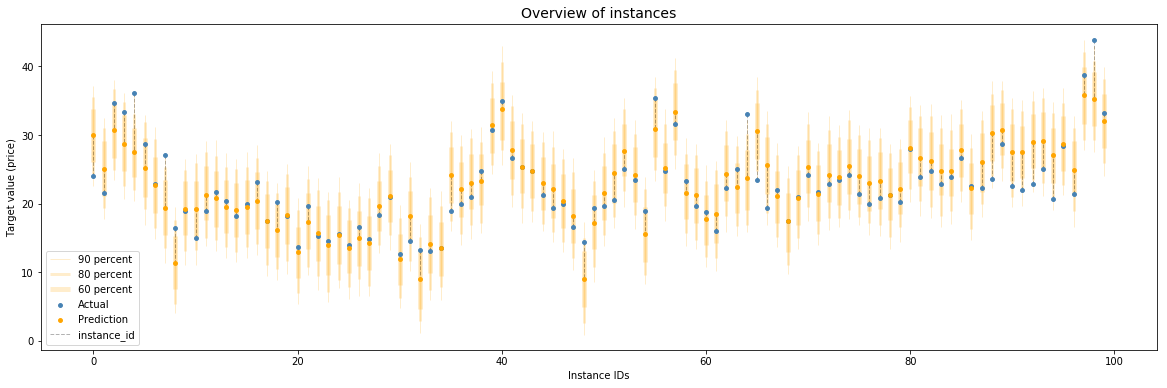

In [525]:
overview_plot(y, y_pred_samples["y_hat"], 0, 100);

### ADVI

https://docs.pymc.io/notebooks/variational_api_quickstart.html

https://www.quora.com/What-is-variational-inference

https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/variational-inference-i.pdf

In [381]:
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

model = pm.Model()
with model:
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    intercept = pm.Normal('Intercept', df["y"].mean(), sd=5)
    beta = pm.Normal('beta', mu=0, sd=20, shape=X.shape[1])
    y = pm.Normal('y', mu=tt.dot(beta, X_standardized.T) + intercept, sd=sigma, observed=df["y"])

In [382]:
with model:
    inference = pm.ADVI()
    approx = pm.fit(n=80000, method=inference, obj_optimizer=pm.adamax(learning_rate=0.03))
    trace = approx.sample(draws=5000)
    burned_trace = trace[500:]

Average Loss = 1,565.6: 100%|██████████| 80000/80000 [00:46<00:00, 1736.01it/s]
Finished [100%]: Average Loss = 1,565.6


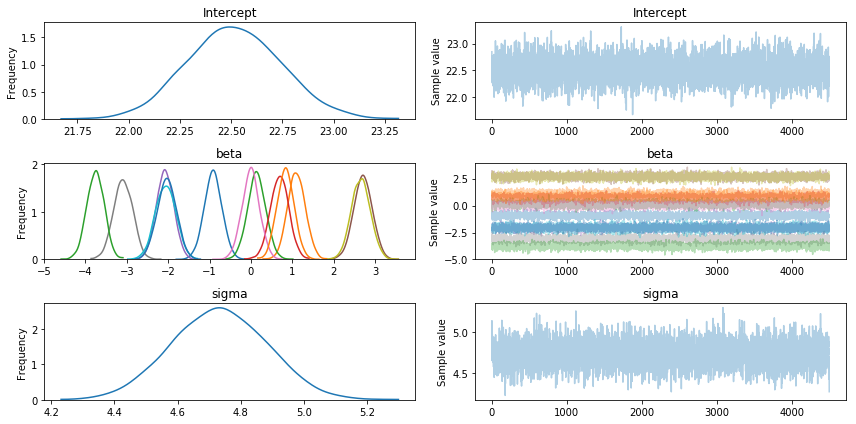

In [383]:
pm.traceplot(burned_trace);

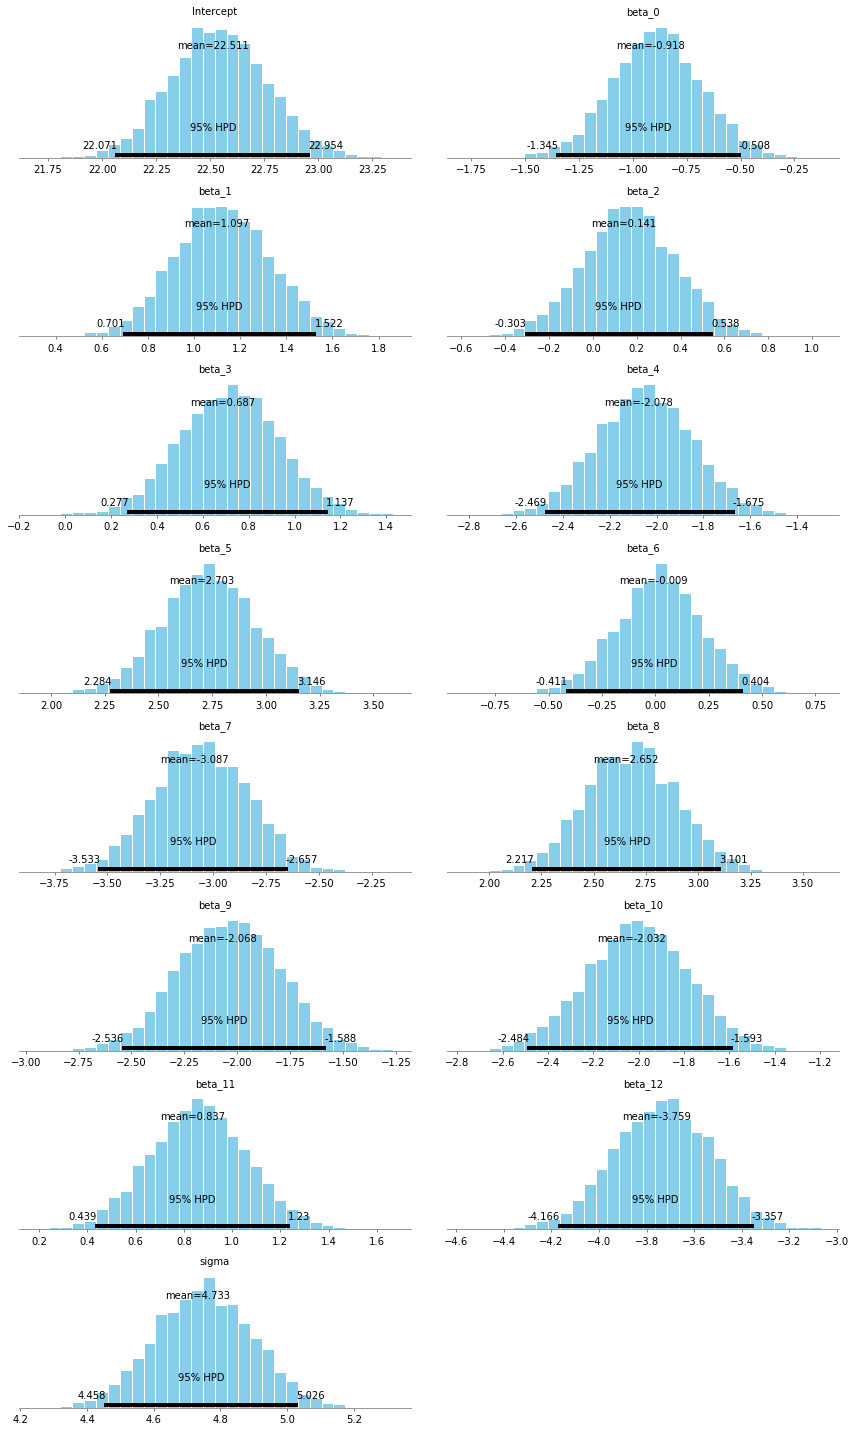

In [384]:
pm.plot_posterior(burned_trace);

In [385]:
y_pred = pm.sample_ppc(burned_trace, model=model, samples=100)

100%|██████████| 100/100 [00:00<00:00, 738.93it/s]


In [386]:
y_pred_val = np.mean(y_pred["y"], axis=0)

In [387]:
np.mean(np.abs(df["y"] - y_pred_val) / df["y"])

0.16652472010152544